In [1]:
# Import all necessary libraries for this example
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import DCCSMLM
import sys
from scipy.optimize import curve_fit

%matplotlib notebook

In [2]:
filename = "ExampleData/20190316_beads.SciH5"

raw_data = DCCSMLM.DCCSMLM() # Initialize an empty DCCSMLM object
channels = raw_data.load_channel(filename) # Get a list of all available channels


# Iterate over all available channels
for channel_id in channels:
    if channel_id.endswith(".locs"): # Only load channels that end with ".locs" in their name
        print(f"Loading {channel_id}")
        # Load a channel and assign the "a1", "a2", "b1"... identifier as channel_id
        raw_data.load_channel(filename, channel=channel_id, channel_id=channel_id[-7:-5])
        



Please define a channel to load. Available channels are:
Loading 20190316_bead_a1.locs
Loading 20190316_bead_a2.locs
Loading 20190316_bead_b1.locs
Loading 20190316_bead_b2.locs
Loading 20190316_bead_c1.locs
Loading 20190316_bead_c2.locs
Loading 20190316_bead_d1.locs
Loading 20190316_bead_d2.locs
Loading 20190316_bead_e1.locs
Loading 20190316_bead_e2.locs
Loading 20190316_bead_f1.locs
Loading 20190316_bead_f2.locs
Loading 20190316_bead_g1.locs
Loading 20190316_bead_g2.locs
Loading 20190316_bead_h1.locs
Loading 20190316_bead_h2.locs
Loading 20190316_bead_i1.locs
Loading 20190316_bead_i2.locs
Loading 20190316_bead_j1.locs
Loading 20190316_bead_j2.locs
Loading 20190316_bead_k1.locs
Loading 20190316_bead_k2.locs
Loading 20190316_bead_l1.locs
Loading 20190316_bead_l2.locs
Loading 20190316_bead_m1.locs
Loading 20190316_bead_m2.locs
Loading 20190316_bead_n1.locs
Loading 20190316_bead_n2.locs
Loading 20190316_bead_o1.locs
Loading 20190316_bead_o2.locs
Loading 20190316_bead_p1.locs
Loading 20190

In [3]:
# Iterate over all channels
for channel in raw_data.channel:
    # Find fiducial markers (beads) by identifying signal clusters with high intensity
    # emissions (intensity_threshold), lasting for many frames (min_samples) and being 
    # close to one another (eps)
    raw_data.channel[channel].find_clusters(intensity_threshold=50, min_samples=40, 
                                            eps=50, save_column="bead_id") 



<IPython.core.display.Javascript object>


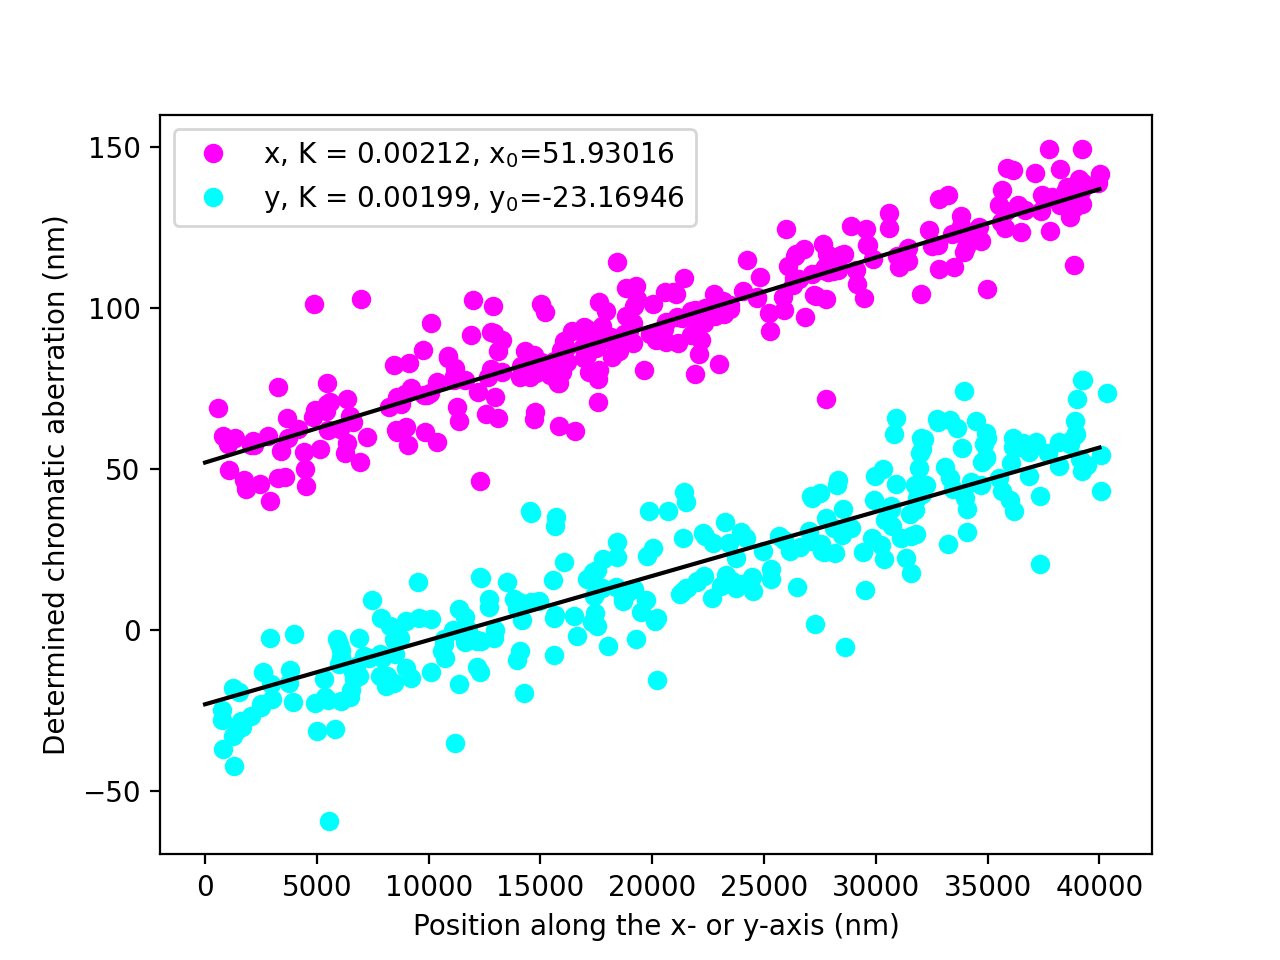

In [4]:
def linear_func(x, a, b):
    # This returns the result of a simple linear function
    return a * x + b

# List of the channels to analyze with a combination of (mVenus channel, PAmCherry channel)
# This is specific to the example file contained within the repository and must be changed
# for every file
ca_list = [("a1", "a2"),("b1", "b2"), ("c1", "c2"),("d1", "d2"),("e1", "e2"), ("f1", "f2"),
          ("g1", "g2"),("h1", "h2"), ("i1", "i2"),("j1", "j2"),("k1", "k2"), ("l1", "l2"),
          ("m1", "m2"),("n1", "n2"), ("o1", "o2"),("p1", "p2"),("q1", "q2"), ("r1", "r2"),
          ("s1", "s2"),("t1", "t2")]

ca = pd.DataFrame([]) # This will contain the parameters of the linear fit of the CA
# This will contain the individual values used for fitting. Only required for display purposes.
ca_df = pd.DataFrame([]) 

# Iterate over all mVenus/PAmCherry combinations
for ca_set in ca_list:
    # Determine closest clusters (as surrogate for chromatic aberration (CA)) of channel_two
    # relative to channel_one
    ca_channel, ca_channel_df = raw_data.determine_chromatic_aberration(ca_set[0], ca_set[1], "bead_id",
                                                                        distance_cutoff=350)
    # Convert ca_channel into a Pandas DataFrame for easier handling
    ca_channel = pd.DataFrame([ca_channel])
    # Concatenate the current cluster list (ca_channel) to the overall list (ca)
    ca = pd.concat([ca, ca_channel])
    
    ca_df = pd.concat([ca_df, ca_channel_df]) # Only required for display purposes

 
ca.reset_index(inplace=True, drop=True) 
ca.columns=["Kx", "Ky", "x0", "y0"] # Rename the columns
ca = ca.mean() # Obtain the mean values


################ Create and display a graph of the results and the linear fit


plt.figure()
# Plot the position of each bead on the x-axis versus the determined
# chromatic abberation.

plt.plot(ca_df.x, ca_df.x_distance, marker="o", lw=0.0, color="magenta", 
         label=f"x, K = {round(ca.Kx,5)}, x$_0$={round(ca.x0, 5)}")
# Plot the fit of the CA along the x-axis
plt.plot([0, 40000], [linear_func(0, ca.Kx, ca.x0), linear_func(40000, ca.Kx, ca.x0)], color="black")

# Plot the position of each bead on the y-axis versus the determined
# chromatic abberation.
plt.plot(ca_df.y, ca_df.y_distance, marker="o", lw=0.0, color="cyan", 
         label=f"y, K = {round(ca.Ky, 5)}, y$_0$={round(ca.y0, 5)}")

# Plot the fit of the CA along the y-axis
plt.plot([0, 40000], [linear_func(0, ca.Ky, ca.y0), linear_func(40000, ca.Ky, ca.y0)], color="black")

plt.xlabel("Position along the x- or y-axis (nm)")
plt.ylabel("Determined chromatic aberration (nm)")
plt.legend()
plt.show()

In [5]:
# Save the parameters (Kx and x0 for the CA along the x-axis, Ky and y0 for the
# CA along the y-axis) of the mean chromatic aberration.
# The resulting CSV file can be loaded by other scripts and used for CA correction

ca_parameters = pd.DataFrame({"label": ["PAmCherry"], 
                             "Kx": [ca.Kx], "x0": [ca.x0], "Ky": [ca.Ky], "y0": [ca.y0]})
ca_parameters.to_csv("ExampleData/CA_parameters.csv")